In [1]:
# %matplotlib widget

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data_io import read_iq_data
from visualisation import PDRPlotter
from interference_utils import pdr_vs_snr_analysis_parallel
from receiver import ReceiverType, DemodulationType
from demodulation import TEDType


def load_and_plot_pkl_data(title="PDR vs SNR Analysis"):
    """Loads all .pkl files in the current directory and generates a plot"."""
    # Get all .pkl files in the current directory
    pkl_files = [f for f in os.listdir() if f.endswith(".pkl")]

    # Load each .pkl file into a dictionary
    data = {}
    for file in pkl_files:
        with open(file, "rb") as f:
            data[file] = pickle.load(f)

    # Define plotting parameters
    colours = ["blue", "red", "green", "purple", "orange", "brown", "pink", "gray", "cyan", "magenta"]
    linestyles = ["-", "--", "-.", ":"]
    markers = ["o", "s", "D", "^", "v", "<", ">", "p", "*", "X"]

    # Create an instance of PDRPlotter
    plotter = PDRPlotter()

    # Add each data trace to the plotter with random styles
    for filename, values in data.items():
        plotter.add_trace(
            values,
            filename,
            colour=random.choice(colours),
            linestyle=random.choice(linestyles),
            marker=random.choice(markers),
        )

    # Plot the data
    plotter.plot(title=title)

# BLE example

In [2]:
bw_snrs: dict = {"BLE": 1.5e6, "IEEE802154": 3e6}
filenames: dict = {"BLE": "BLE_0dBm.dat", "IEEE802154": "802154_0dBm.dat"}  # Open BLE file

fs = 10e6  # Hz
receiver_type: ReceiverType = "BLE"
iq_samples: np.ndarray = read_iq_data(f"../../capture_nRF/data/new/{filenames[receiver_type]}")

demodulation_type: DemodulationType = "INSTANTANEOUS_FREQUENCY"
ted_type: TEDType = "MOD_MUELLER_AND_MULLER"

snr_range = range(6, 18, 1)
noise_realisations = int(1e4)

In [3]:
ted_types: list[TEDType] = [
    "MOD_MUELLER_AND_MULLER",
]

pdr = []

for ted in ted_types:
    result = pdr_vs_snr_analysis_parallel(
        iq_samples=iq_samples,
        snr_range=snr_range,
        bw_snr=bw_snrs[receiver_type],
        fs=fs,
        receiver_type=receiver_type,
        demodulation_type=demodulation_type,
        ted_type=ted,
        noise_realisations=noise_realisations,
    )
    pdr.append(result)
    filename = f"before_iir_simple_squelch_{ted}.pkl"
    with open(filename, "wb") as file:
        pickle.dump(result, file)

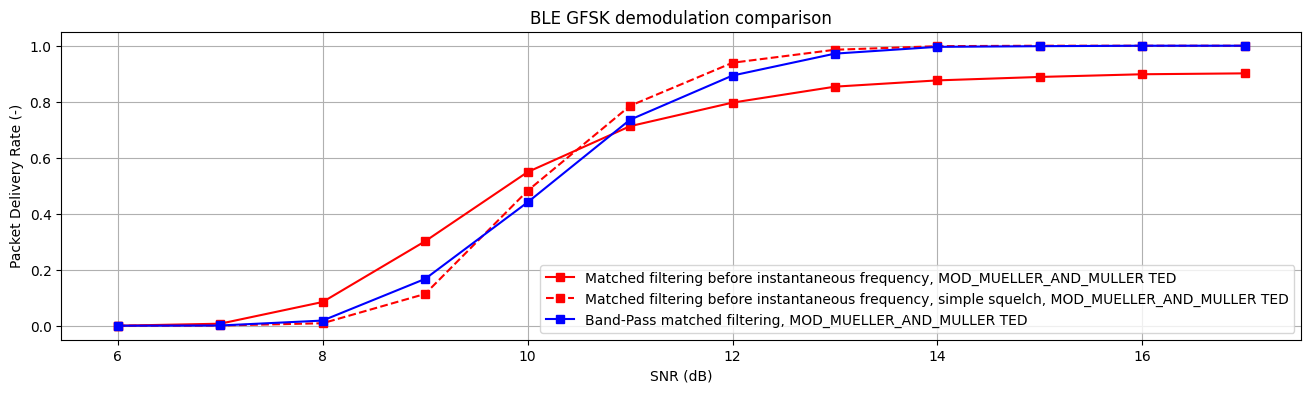

In [5]:
ted_types: list[TEDType] = [
    "MOD_MUELLER_AND_MULLER",
]

opened_files = []
# Instantaneous frquency
for ted in ted_types:
    with open(f"before_iir_{ted}.pkl", "rb") as f:
        opened_files.append(pickle.load(f))

for ted in ted_types:
    with open(f"before_iir_simple_squelch_{ted}.pkl", "rb") as f:
        opened_files.append(pickle.load(f))

# Band pass
with open("band_pass_MOD_MUELLER_AND_MULLER.pkl", "rb") as f:
    band_pass = pickle.load(f)

markers = ["o", "s", "D", "^", "v", "<", ">", "p", "*", "X"]
plotter = PDRPlotter()
# Instantaneous frquency
plotter.add_trace(
    opened_files[0],
    f"Matched filtering before instantaneous frequency, {ted_types[0]} TED",
    colour="red",
    linestyle="-",
    marker="s",
)
plotter.add_trace(
    opened_files[1],
    f"Matched filtering before instantaneous frequency, simple squelch, {ted_types[0]} TED",
    colour="red",
    linestyle="--",
    marker="s",
)
# Band pass
plotter.add_trace(
    band_pass, f"Band-Pass matched filtering, {'MOD_MUELLER_AND_MULLER'} TED", colour="blue", linestyle="-", marker="s"
)
plotter.plot(title="BLE GFSK demodulation comparison", figsize=(16, 4))

In [ ]:
# load_and_plot_pkl_data()

# IEEE 802.15.4 example 